# Designing adaptive experiments to study working memory

Suppose you are shown a sequence of digits

$$ 1\ 4\ 7\ 0\ 9 $$

which are then hidden. You have to to reproduce the sequence exactly from memory. In the next round, the length of the sequence may be different

$$ 6\ 5\ 0\ 2\ 8\ 0 .$$

The longest sequence that you can remember is your working memory capacity. In this tutorial, we build a Bayesian model for working memory, and use it to run an adaptive sequence of experiments that very quickly learn someone's working memory capacity.


## A model of working memory
Our model for a single round of the digits experiment described above has three components: the length $l$ of the sequence that the participant has to remember, the participant's true working memory capacity $\theta$, and the outcome of the experiment $y$ which indicates whether they were able to remember the sequence successfully ($y=1$) or not ($y=0$).

In [89]:
import pyro
import pyro.distributions as dist


sensitivity = 1.0
prior_mean = torch.tensor(7.0)
prior_sd = torch.tensor(2.5)


def model(l):
    theta = pyro.sample("theta", dist.Normal(prior_mean, prior_sd))
    logit_p = sensitivity * (theta - l)
    y = pyro.sample("y", dist.Bernoulli(logits=logit_p))
    return y

The probability of successfully remembering the sequence is plotted below, for five random samples of $\theta$

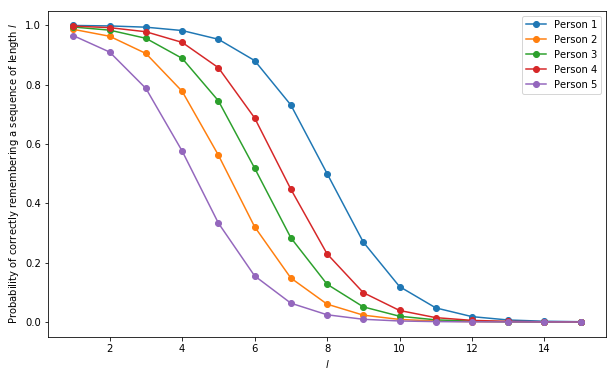

In [90]:
import torch
import matplotlib.pyplot as plt

theta = (prior_mean + prior_sd * torch.randn((5,1)))
plt.figure(figsize=(10, 6))
l = torch.arange(1, 16, dtype=torch.float)
prob = torch.sigmoid(sensitivity * (theta - l))
for curve in torch.unbind(prob, 0):
    plt.plot(l.numpy(), curve.numpy(), marker='o')
plt.xlabel("$l$")
plt.ylabel("Probability of correctly remembering a sequence of length $l$")
plt.legend(["Person {}".format(i+1) for i in range(5)])

## Inference in the model

With the model in hand, we quickly demonstrate variational inference in Pyro for this model. We will set up the inference to handle any number of rounds.

In [106]:
from contextlib import ExitStack
from pyro.contrib.util import iter_plates_to_shape, rexpand

def multiround_model(l):
    # The shape of l is (batch dims..., number of rounds)
    with ExitStack() as stack:
        for plate in iter_plates_to_shape(l.shape[:-1]):
            stack.enter_context(plate)
        theta = pyro.sample("theta", dist.Normal(prior_mean, prior_sd))
        theta = rexpand(theta, l.shape[-1])
        logit_p = sensitivity * (theta - l)
        y = pyro.sample("y", dist.Bernoulli(logits=logit_p).to_event(1))
        return y

We also define a Normal guide for variational inference.

In [107]:
from torch.distributions.constraints import positive

def guide(l):
    posterior_mean = pyro.param("posterior_mean", prior_mean)
    posterior_sd = pyro.param("posterior_sd", prior_sd, constraint=positive)
    pyro.sample("theta", dist.Normal(posterior_mean, posterior_sd))

We finally specify the following data

In [108]:
l_data = torch.tensor([5., 7., 9.])
y_data = torch.tensor([1., 1., 0.])

In [109]:
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

conditioned_model = pyro.condition(multiround_model, {"y": y_data})
svi = SVI(conditioned_model,
          guide,
          Adam({"lr": .001}),
          loss=Trace_ELBO(),
          num_samples=100)
pyro.clear_param_store()
num_iters = 5000
for i in range(num_iters):
    elbo = svi.step(l_data)
    if i % 500 == 0:
        print("Elbo loss: {}".format(elbo))

Elbo loss: 0.8117433190345764
Elbo loss: 0.8812401294708252
Elbo loss: 3.60206937789917
Elbo loss: 1.1630702018737793
Elbo loss: 1.1569448709487915
Elbo loss: 1.3571895360946655
Elbo loss: 1.4438081979751587
Elbo loss: 1.24165678024292
Elbo loss: 1.2489147186279297
Elbo loss: 1.2772602438926697


In [110]:
print("Posterior mean:", pyro.param("posterior_mean").item())
print("Posterior std dev:", pyro.param("posterior_sd").item())

Posterior mean: 8.201149940490723
Posterior std dev: 1.36166512966156


## Bayesian optimal experimental design
So far so standard. In the previous example, the lengths `l_data` were not chosen with a great deal of forethought. Fortunately, in a setting like this, it is possible to use a more sophisticated strategy to choose the sequence lengths to make the most of every question we ask.

We do this using Bayesian optimal experimental design (BOED). In BOED, we are interested in designing experiments that maximise the information gain, which is defined formally as

$$ \text{IG}(l, y) = KL(p(\theta|y,l)||p(\theta)) .$$

In words, the information gain is the KL divergence from the posterior to the prior. It therefore represents the distance we "move" the posterior by running an experiment with length $l$ and getting back the outcome $y$.

Unfortunately, we will not know $y$ until we actually run the experiment. Therefore, we choose $l$ on the basis of the *expected* information gain

$$\text{EIG}(l) = \mathbb{E}_{y\sim p(y|\theta,l)}\quad [KL(p(\theta|y,l)||p(\theta))]. $$

Because it features the posterior density $p(y|\theta,l)$, the EIG is not immediately tractable. However, we can make use of the following formula for EIG

$$\text{EIG}(l) = \min_q \mathbb{E}_{\theta,y \sim p(\theta)p(y|\theta,l)}\quad \left[ \log \frac{p(y|\theta,l)}{q(y)} \right].$$

### Optimal experimental design in Pyro
Fortunately, Pyro comes ready with tools to estimate the EIG. All we have to do is define the "marginal guide" $q(y)$ in the formula above.

In [155]:
def marginal_guide(design, observation_labels, target_labels):
    p_logit = pyro.param("p_logit", torch.zeros(design.shape[-2:]))
    pyro.sample("y", dist.Bernoulli(logits=p_logit).to_event(1))

In [159]:
from pyro.contrib.oed.eig import marginal_eig

# The shape is (number designs, 1)
candidate_designs = torch.arange(1, 15, dtype=torch.float).unsqueeze(-1)
pyro.clear_param_store()
eig = marginal_eig(multiround_model, candidate_designs, "y", "theta", num_samples=100,
                   num_steps=1000, guide=marginal_guide, optim=Adam({"lr": 0.001}),
                   final_num_samples=1000)

In [160]:
print(eig)
print("p_logit", pyro.param("p_logit"))

tensor([0.3143, 0.3060, 0.2816, 0.2569, 0.2284, 0.2423, 0.2594, 0.3097, 0.2788,
        0.2298, 0.2471, 0.2543, 0.2670, 0.2927], grad_fn=<DivBackward0>)
p_logit tensor([[ 0.8835],
        [ 0.8815],
        [ 0.8734],
        [ 0.8569],
        [ 0.8356],
        [ 0.7566],
        [ 0.5557],
        [ 0.1038],
        [-0.3885],
        [-0.7047],
        [-0.8014],
        [-0.8497],
        [-0.8685],
        [-0.8773]], requires_grad=True)


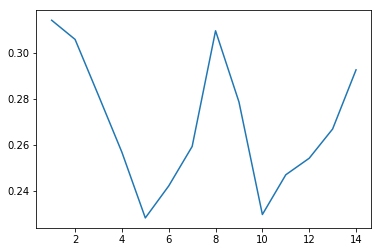

In [161]:
plt.plot(candidate_designs.numpy(), eig.detach().numpy())